In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, Flatten, Dropout, InputLayer
from keras.initializers import RandomNormal
from keras.layers import Input
from keras.optimizers import Adam
from keras.metrics import Mean
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from PIL import Image
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 21 06:50:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Define constants

In [ ]:
np.random.seed(10)
load_model = False
noise_dim = 100
batch_size = 32
img_rows, img_cols, channels = 128, 128, 3

Load dataset

In [ ]:
data_folder = ''
data = image_dataset_from_directory(
    data_folder,
    batch_size=batch_size,
    image_size=(img_rows, img_cols),
    shuffle=True,
    label_mode = None
)
data = data.map(lambda x: x / 255.0)

Found 10176 files belonging to 1 classes.


Print example image

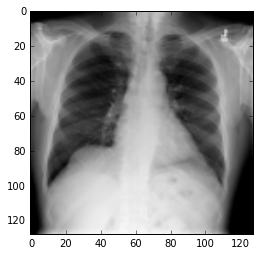

In [ ]:
for x in data:
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Create generator

In [ ]:
def create_generator():
    generator = Sequential()
    
    generator.add(InputLayer(input_shape=(noise_dim,)))
    generator.add(Dense(8*8*1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((8, 8, 1024)))

    generator.add(Conv2DTranspose(512,  kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2D(3, kernel_size=5, padding='same', activation='tanh'))

    return generator

Create discriminator

In [ ]:
def create_discriminator():
    discriminator = Sequential()

    discriminator.add(InputLayer(input_shape=(128, 128, 3)))
    discriminator.add(Conv2D(64, kernel_size=5, strides=1, padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Conv2D(1024, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Flatten())   
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

Define model

In [ ]:
generator = create_generator()
discriminator = create_discriminator()

generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6619136   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 512)       0

Create DCGAN

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, noise_dim):
      super(GAN, self).__init__()
      self.discriminator = discriminator
      self.generator = generator
      self.noise_dim = noise_dim
    
    def compile(self, disc_optimizer, gen_optimizer, loss_fn):
      super(GAN, self).compile()
      self.disc_optimizer = disc_optimizer
      self.gen_optimizer = gen_optimizer
      self.loss_fn = loss_fn
      self.disc_loss_metric = Mean(name="disc_loss")
      self.gen_loss_metric = Mean(name="gen_loss")

    @property
    def metrics(self):
        return [self.disc_loss_metric, self.gen_loss_metric]

    def train_step(self, real_images):

        # Sample random points in the latent space
        noise = tf.random.normal(shape=(batch_size, self.noise_dim))
        # Decode them to fake images
        fake_images = self.generator(noise)

        # Combine them with real images
        combined_images = tf.concat([fake_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Add noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            disc_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            gen_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.disc_loss_metric.update_state(disc_loss)
        self.gen_loss_metric.update_state(gen_loss)

        return {
            "disc_loss": self.disc_loss_metric.result(),
            "gen_loss": self.gen_loss_metric.result(),
        }



Define training callbacks

In [ ]:
class PrintCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    #display.clear_output(wait=True)
    noise = tf.random.normal(shape=(18, 100))
    generated_imgs = self.model.generator.predict(noise)
    for i in range(generated_imgs.shape[0]):
      plt.subplot(6, 6, i+1)
      plt.imshow(generated_imgs[i, :, :, 0], cmap='gray')
      plt.axis('off')  
    plt.show()

    

In [ ]:
checkpoint_path = ''
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_freq='epoch')

Train model

Epoch 1/200
318/318 [==============================] - 859s 3s/step - disc_loss: 0.4085 - gen_loss: 4.7826


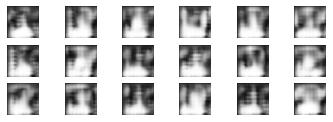

Epoch 2/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.5265 - gen_loss: 4.1984


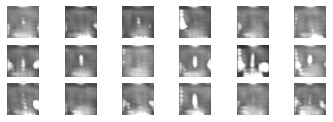

Epoch 3/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.3895 - gen_loss: 7.0481


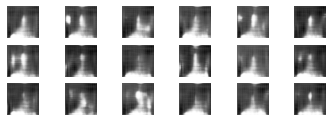

Epoch 4/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4520 - gen_loss: 4.6303


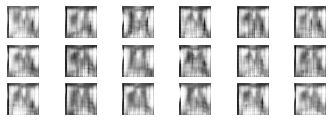

Epoch 5/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.7381 - gen_loss: 5.6737


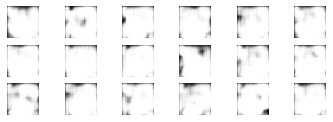

Epoch 6/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4665 - gen_loss: 8.5750


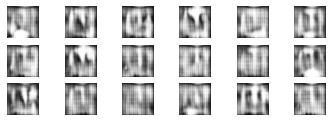

Epoch 7/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.5954 - gen_loss: 3.4255


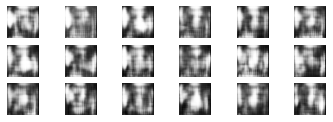

Epoch 8/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.8235 - gen_loss: 4.9152


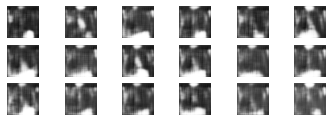

Epoch 9/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.5225 - gen_loss: 3.9952


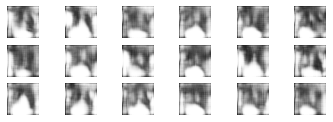

Epoch 10/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.5001 - gen_loss: 3.7054


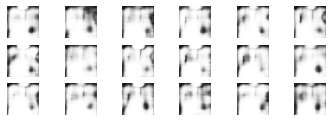

Epoch 11/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.5216 - gen_loss: 2.6815


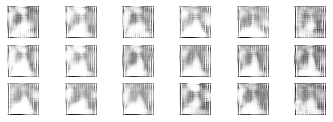

Epoch 12/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.4520 - gen_loss: 4.1033


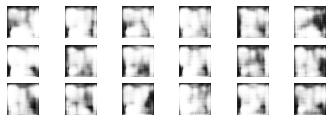

Epoch 13/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.5681 - gen_loss: 4.0435


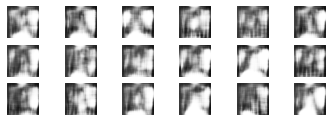

Epoch 14/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.4753 - gen_loss: 3.5793


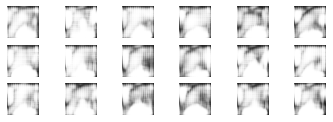

Epoch 15/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4714 - gen_loss: 3.1980


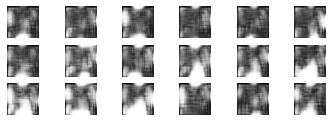

Epoch 16/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4365 - gen_loss: 3.2618


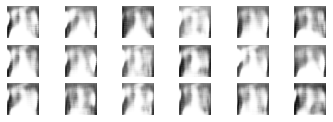

Epoch 17/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4016 - gen_loss: 3.6930


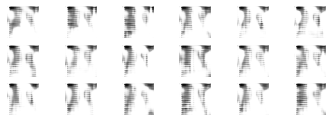

Epoch 18/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.4519 - gen_loss: 3.3943


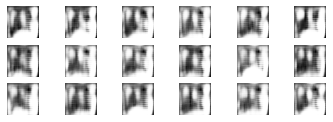

Epoch 19/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4413 - gen_loss: 4.1688


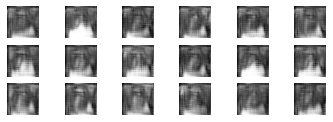

Epoch 20/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.3749 - gen_loss: 3.6285


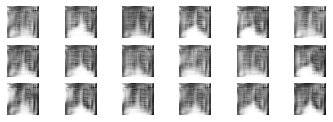

Epoch 21/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.4335 - gen_loss: 4.3737


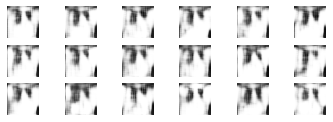

Epoch 22/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.4573 - gen_loss: 3.3909


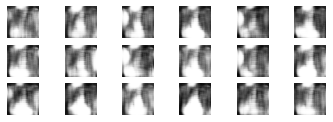

Epoch 23/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.3815 - gen_loss: 4.7174


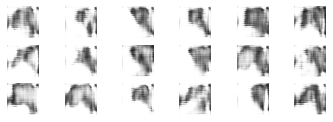

Epoch 24/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.3858 - gen_loss: 3.9110


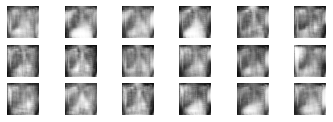

Epoch 25/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.4130 - gen_loss: 3.8846


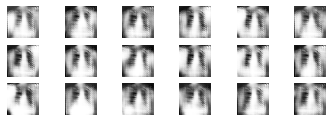

Epoch 26/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.3958 - gen_loss: 3.6023


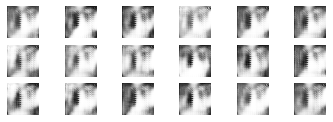

Epoch 27/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.3805 - gen_loss: 3.4269


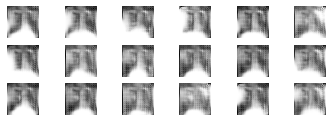

Epoch 28/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.3620 - gen_loss: 3.2566


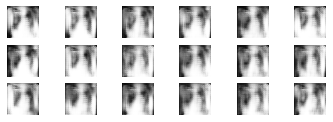

Epoch 29/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.3437 - gen_loss: 3.2977


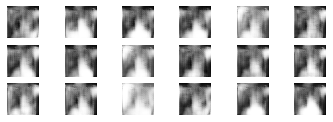

Epoch 30/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.3719 - gen_loss: 4.1180


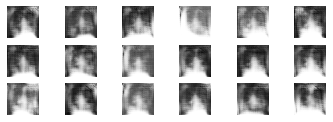

Epoch 31/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2888 - gen_loss: 3.9166


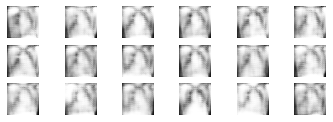

Epoch 32/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.4164 - gen_loss: 3.7202


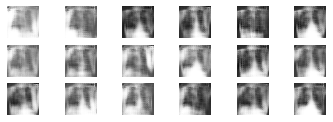

Epoch 33/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.3168 - gen_loss: 4.1314


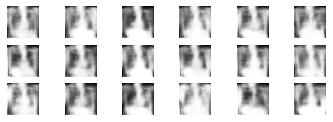

Epoch 34/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2909 - gen_loss: 3.1752


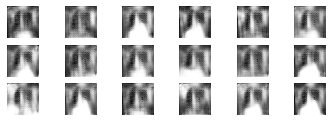

Epoch 35/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.3081 - gen_loss: 3.9202


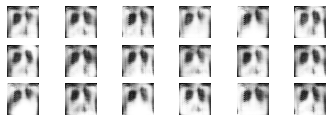

Epoch 36/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2918 - gen_loss: 3.6486


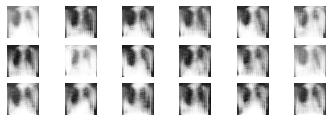

Epoch 37/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2776 - gen_loss: 3.7672


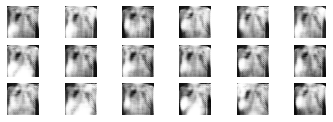

Epoch 38/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2514 - gen_loss: 4.2464


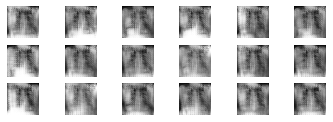

Epoch 39/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2294 - gen_loss: 4.3915


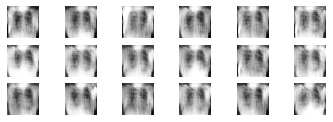

Epoch 40/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2345 - gen_loss: 3.8346


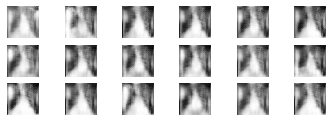

Epoch 41/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2080 - gen_loss: 4.4855


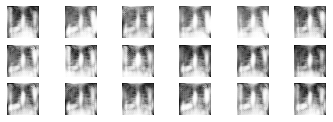

Epoch 42/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2533 - gen_loss: 5.0498


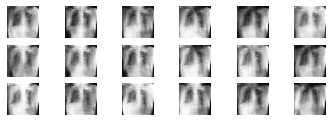

Epoch 43/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2332 - gen_loss: 4.6270


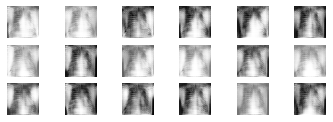

Epoch 44/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2868 - gen_loss: 4.7463


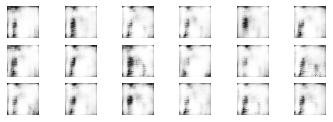

Epoch 45/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2634 - gen_loss: 5.1256


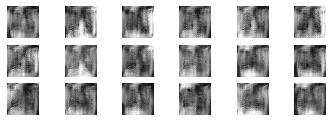

Epoch 46/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2461 - gen_loss: 3.9260


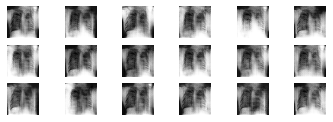

Epoch 47/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2425 - gen_loss: 4.0337


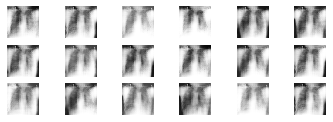

Epoch 48/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2241 - gen_loss: 4.0317


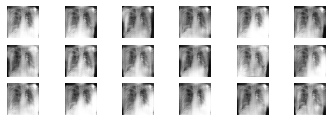

Epoch 49/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2119 - gen_loss: 4.0794


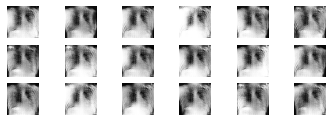

Epoch 50/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2151 - gen_loss: 4.2340


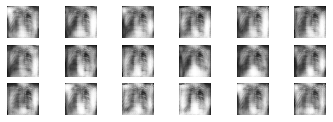

Epoch 51/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.2337 - gen_loss: 4.5919


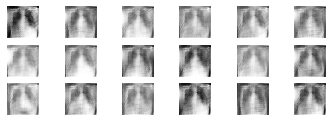

Epoch 52/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2289 - gen_loss: 4.3605


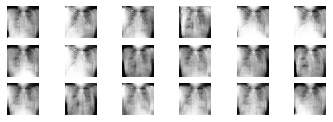

Epoch 53/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1904 - gen_loss: 4.3539


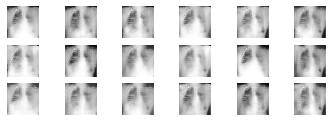

Epoch 54/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1982 - gen_loss: 4.3612


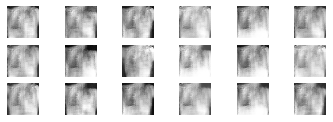

Epoch 55/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.1708 - gen_loss: 4.7748


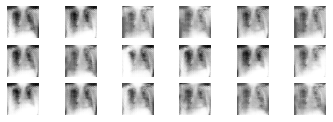

Epoch 56/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2095 - gen_loss: 4.6021


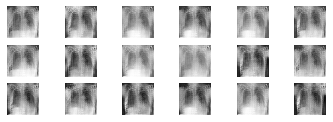

Epoch 57/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.1903 - gen_loss: 4.7702


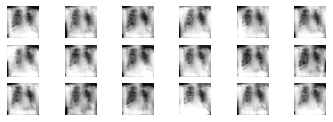

Epoch 58/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1582 - gen_loss: 5.1681


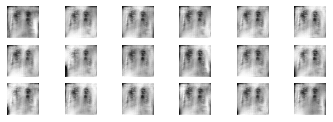

Epoch 59/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.1578 - gen_loss: 5.0345


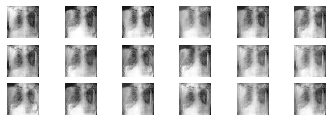

Epoch 60/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1563 - gen_loss: 5.9644


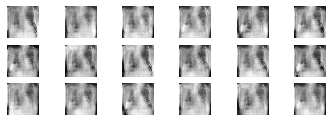

Epoch 61/200
318/318 [==============================] - 144s 454ms/step - disc_loss: 0.1592 - gen_loss: 5.5182


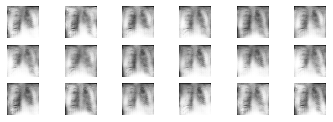

Epoch 62/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1400 - gen_loss: 5.1056


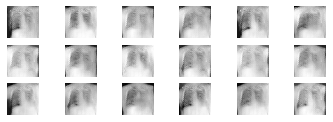

Epoch 63/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1971 - gen_loss: 6.7255


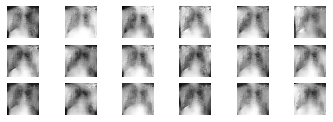

Epoch 64/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1612 - gen_loss: 4.7091


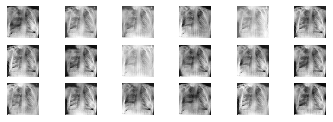

Epoch 65/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1566 - gen_loss: 5.1798


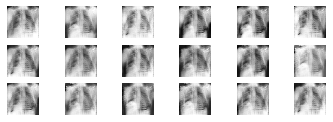

Epoch 66/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1603 - gen_loss: 5.3156


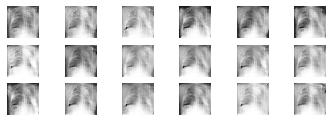

Epoch 67/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1545 - gen_loss: 5.3678


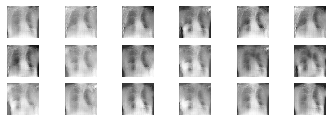

Epoch 68/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.1479 - gen_loss: 5.0804


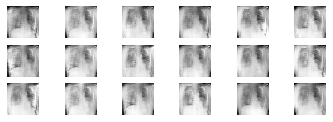

Epoch 69/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1404 - gen_loss: 5.9825


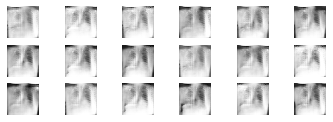

Epoch 70/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1319 - gen_loss: 5.8268


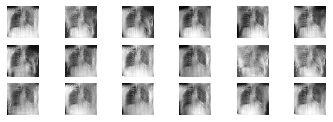

Epoch 71/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1254 - gen_loss: 5.7726


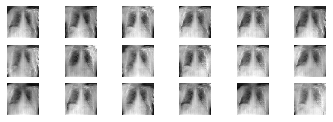

Epoch 72/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1200 - gen_loss: 5.8724


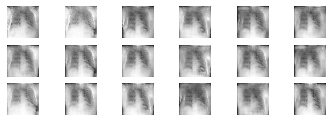

Epoch 73/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1053 - gen_loss: 6.3132


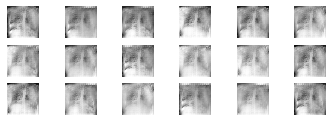

Epoch 74/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1149 - gen_loss: 6.5797


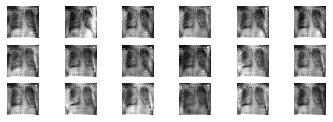

Epoch 75/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1168 - gen_loss: 7.0192


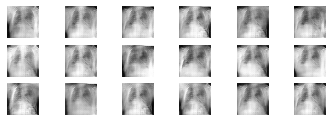

Epoch 76/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.1060 - gen_loss: 6.1353


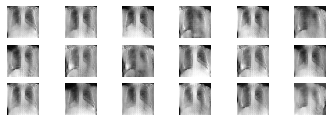

Epoch 77/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.1062 - gen_loss: 7.0245


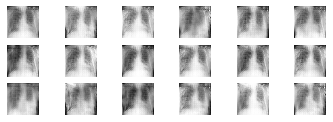

Epoch 78/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0957 - gen_loss: 7.3501


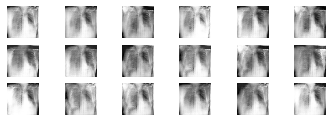

Epoch 79/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0966 - gen_loss: 7.2756


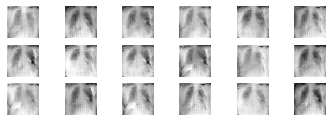

Epoch 80/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0976 - gen_loss: 7.4467


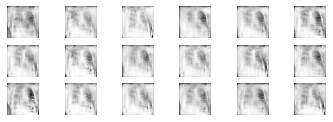

Epoch 81/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0874 - gen_loss: 7.4833


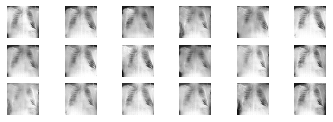

Epoch 82/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.1013 - gen_loss: 8.4321


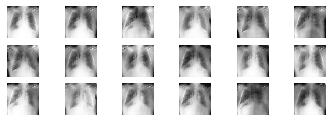

Epoch 83/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0764 - gen_loss: 8.7819


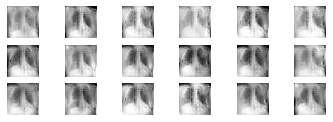

Epoch 84/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0769 - gen_loss: 8.2665


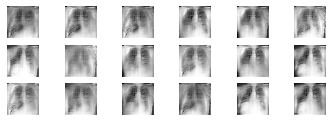

Epoch 85/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0856 - gen_loss: 9.5655


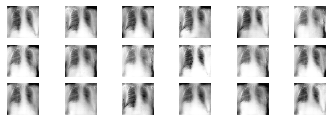

Epoch 86/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0976 - gen_loss: 9.0891


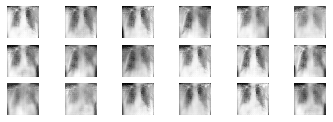

Epoch 87/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0802 - gen_loss: 8.6807


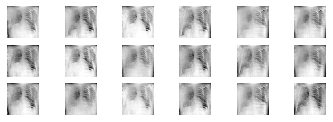

Epoch 88/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0756 - gen_loss: 8.6036


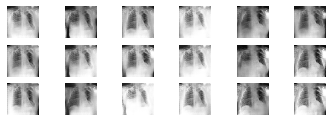

Epoch 89/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0709 - gen_loss: 8.0932


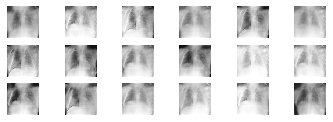

Epoch 90/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0624 - gen_loss: 9.6011


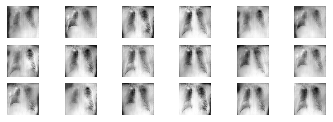

Epoch 91/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0685 - gen_loss: 9.9437


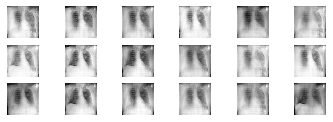

Epoch 92/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0513 - gen_loss: 13.8560


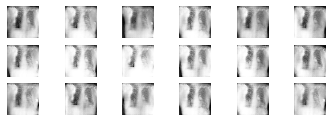

Epoch 93/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0553 - gen_loss: 12.5878


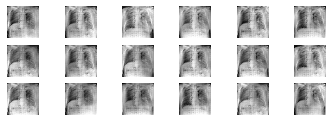

Epoch 94/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0836 - gen_loss: 14.1238


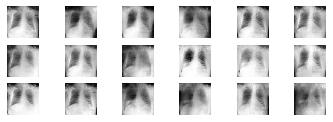

Epoch 95/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0635 - gen_loss: 10.1873


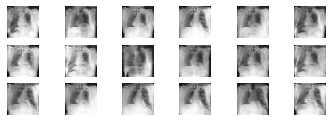

Epoch 96/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0657 - gen_loss: 10.3573


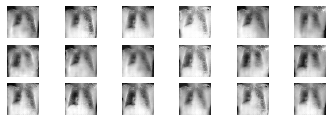

Epoch 97/200
318/318 [==============================] - 144s 451ms/step - disc_loss: 0.0590 - gen_loss: 11.1624


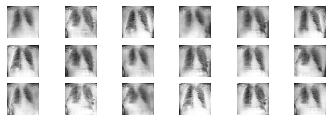

Epoch 98/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0591 - gen_loss: 12.2629


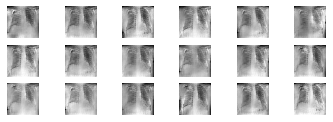

Epoch 99/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0518 - gen_loss: 14.4601


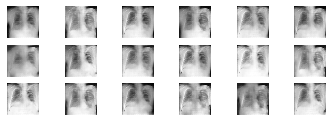

Epoch 100/200
318/318 [==============================] - 144s 451ms/step - disc_loss: 0.0430 - gen_loss: 15.0580


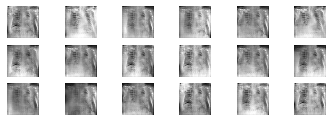

Epoch 101/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0508 - gen_loss: 15.9801


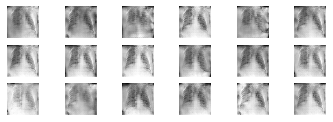

Epoch 102/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0497 - gen_loss: 14.8235


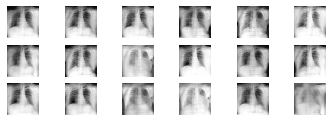

Epoch 103/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0750 - gen_loss: 15.0417


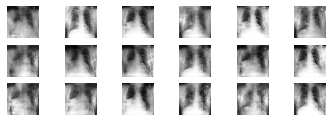

Epoch 104/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0660 - gen_loss: 15.2719


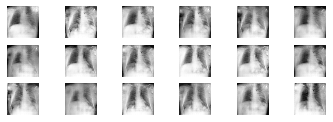

Epoch 105/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0411 - gen_loss: 13.8054


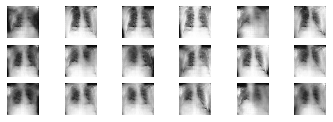

Epoch 106/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0540 - gen_loss: 16.3819


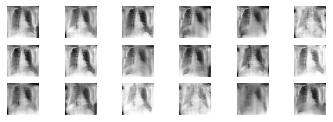

Epoch 107/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0487 - gen_loss: 17.9000


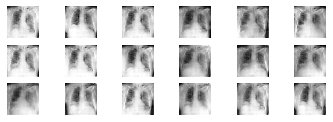

Epoch 108/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0431 - gen_loss: 16.7223


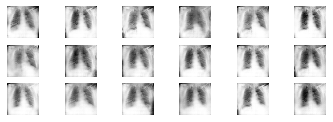

Epoch 109/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0470 - gen_loss: 15.1601


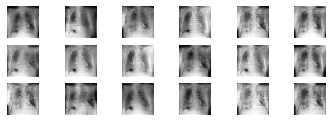

Epoch 110/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0238 - gen_loss: 15.5268


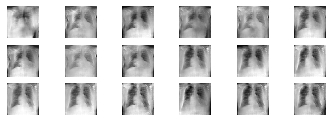

Epoch 111/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.2654 - gen_loss: 18.2814


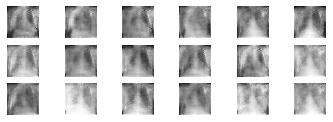

Epoch 112/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0991 - gen_loss: 12.7649


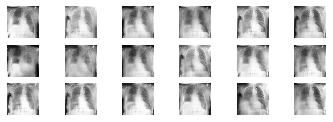

Epoch 113/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0714 - gen_loss: 11.4879


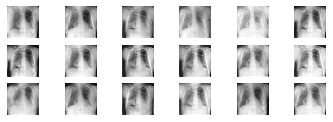

Epoch 114/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0632 - gen_loss: 10.1097


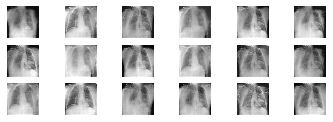

Epoch 115/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0618 - gen_loss: 10.9542


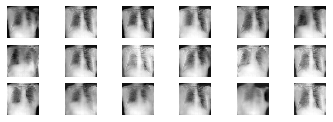

Epoch 116/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0582 - gen_loss: 10.5834


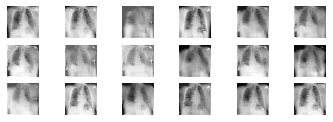

Epoch 117/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0340 - gen_loss: 13.9633


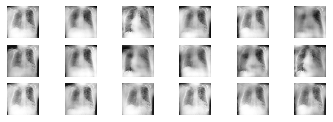

Epoch 118/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0306 - gen_loss: 14.6947


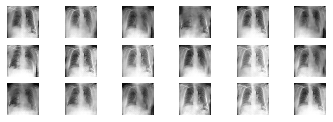

Epoch 119/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0379 - gen_loss: 18.3795


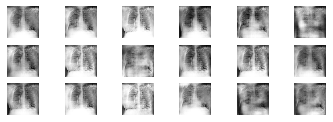

Epoch 120/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0050 - gen_loss: 24.7147


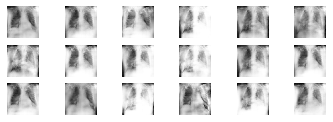

Epoch 121/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0104 - gen_loss: 27.7534


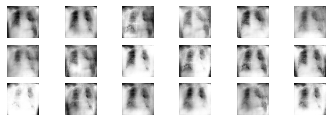

Epoch 122/200
318/318 [==============================] - 144s 452ms/step - disc_loss: 0.0162 - gen_loss: 22.7174


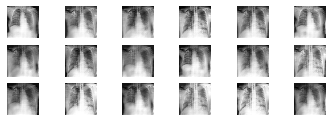

Epoch 123/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0208 - gen_loss: 23.8896


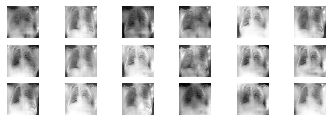

Epoch 124/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0172 - gen_loss: 29.7533


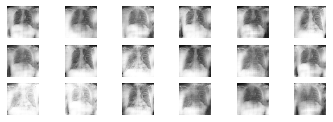

Epoch 125/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.0159 - gen_loss: 30.1130


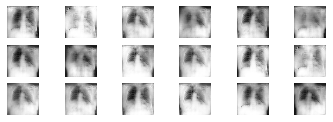

Epoch 126/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0016 - gen_loss: 35.1570


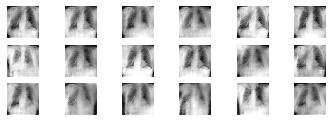

Epoch 127/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0262 - gen_loss: 34.6669


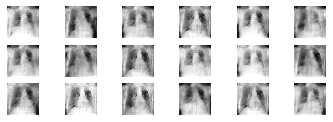

Epoch 128/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0302 - gen_loss: 33.0600


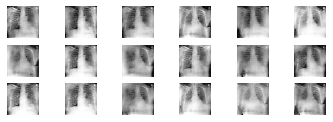

Epoch 129/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0231 - gen_loss: 40.0598


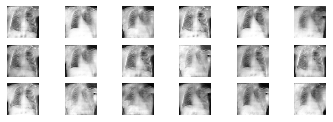

Epoch 130/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0115 - gen_loss: 30.5283


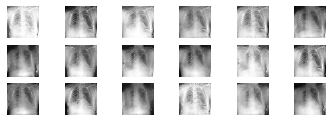

Epoch 131/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0274 - gen_loss: 39.7188


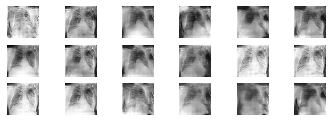

Epoch 132/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0116 - gen_loss: 37.5686


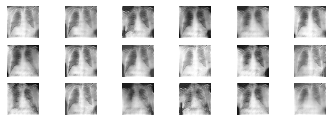

Epoch 133/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0254 - gen_loss: 40.4830


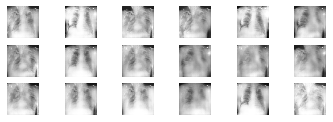

Epoch 134/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0580 - gen_loss: 60.2622


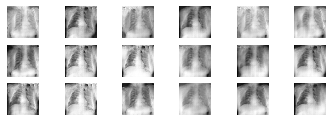

Epoch 135/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0017 - gen_loss: 54.7097


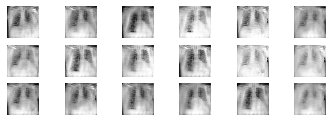

Epoch 136/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0274 - gen_loss: 39.6090


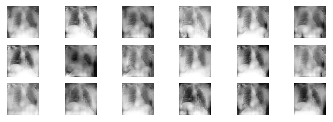

Epoch 137/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0457 - gen_loss: 52.7825


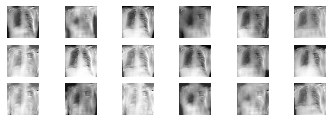

Epoch 138/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0176 - gen_loss: 42.0837


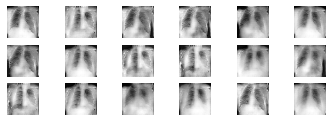

Epoch 139/200
318/318 [==============================] - 145s 454ms/step - disc_loss: 0.0052 - gen_loss: 45.4097


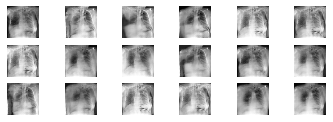

Epoch 140/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0771 - gen_loss: 55.1152


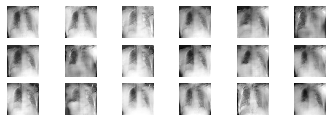

Epoch 141/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0031 - gen_loss: 60.0001


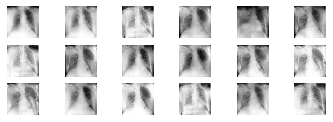

Epoch 142/200
318/318 [==============================] - 145s 454ms/step - disc_loss: 0.0706 - gen_loss: 53.0307


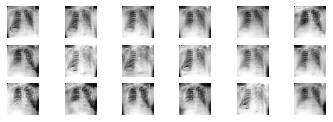

Epoch 143/200
318/318 [==============================] - 144s 453ms/step - disc_loss: 0.0116 - gen_loss: 47.8202


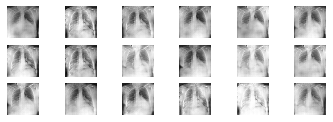

Epoch 144/200
318/318 [==============================] - 145s 453ms/step - disc_loss: -0.0561 - gen_loss: 72.7627


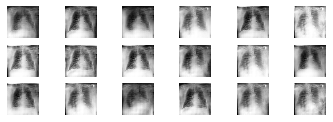

Epoch 145/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0321 - gen_loss: 64.5712


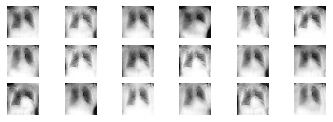

Epoch 146/200
318/318 [==============================] - 145s 454ms/step - disc_loss: -0.0404 - gen_loss: 67.5791


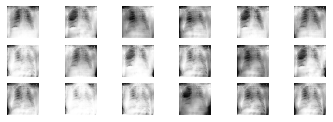

Epoch 147/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.0939 - gen_loss: 100.3451


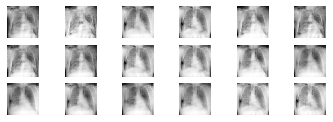

Epoch 148/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1604 - gen_loss: 91.8892


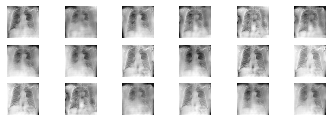

Epoch 149/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.2208 - gen_loss: 108.0169


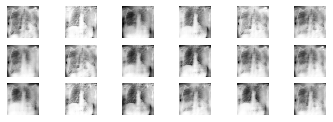

Epoch 150/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.0626 - gen_loss: 98.2049


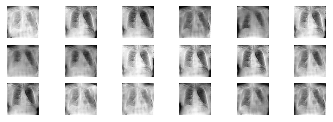

Epoch 151/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1735 - gen_loss: 106.1676


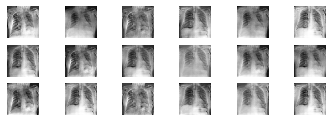

Epoch 152/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.0568 - gen_loss: 91.7516


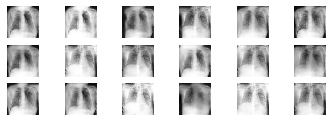

Epoch 153/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1212 - gen_loss: 100.9290


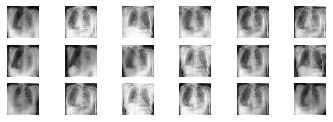

Epoch 154/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1681 - gen_loss: 104.4009


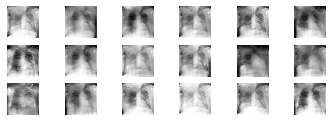

Epoch 155/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1951 - gen_loss: 115.7773


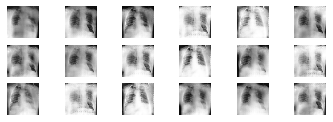

Epoch 156/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.3078 - gen_loss: 166.2235


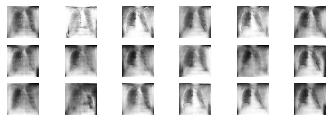

Epoch 157/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1702 - gen_loss: 155.8119


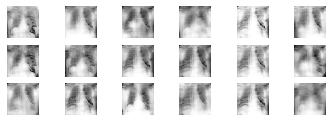

Epoch 158/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.3154 - gen_loss: 201.5901


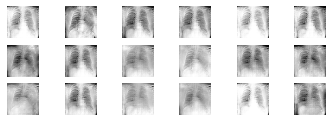

Epoch 159/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6155 - gen_loss: 224.1411


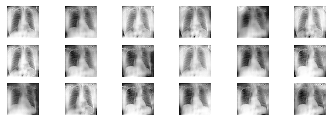

Epoch 160/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.2919 - gen_loss: 188.8990


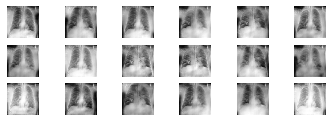

Epoch 161/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.3160 - gen_loss: 215.9436


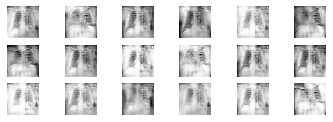

Epoch 162/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.4575 - gen_loss: 208.7537


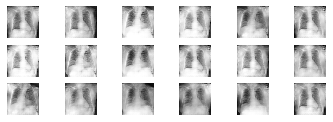

Epoch 163/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.4328 - gen_loss: 211.2749


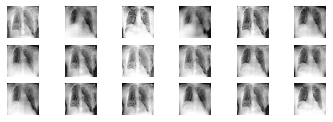

Epoch 164/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.1293 - gen_loss: 168.0440


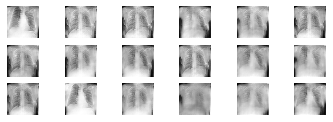

Epoch 165/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.2406 - gen_loss: 194.1134


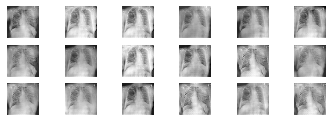

Epoch 166/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.4227 - gen_loss: 215.4757


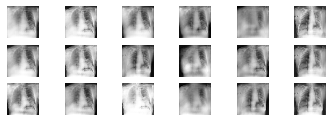

Epoch 167/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.5633 - gen_loss: 252.4727


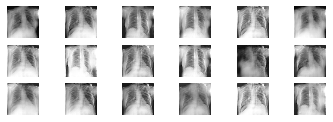

Epoch 168/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.3008 - gen_loss: 213.2611


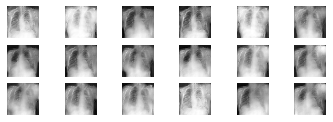

Epoch 169/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.2926 - gen_loss: 206.5106


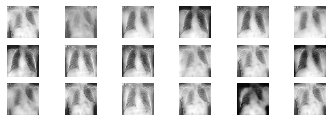

Epoch 170/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6849 - gen_loss: 258.9244


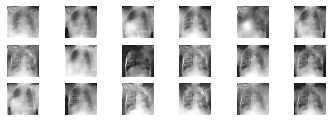

Epoch 171/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6528 - gen_loss: 320.7710


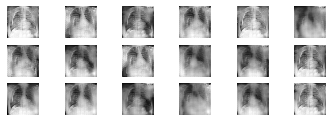

Epoch 172/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.7827 - gen_loss: 347.8763


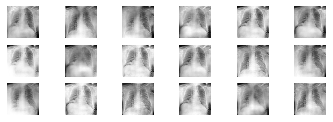

Epoch 173/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.8770 - gen_loss: 387.9433


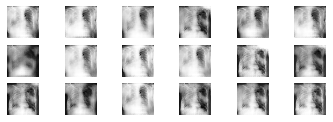

Epoch 174/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.4648 - gen_loss: 385.2660


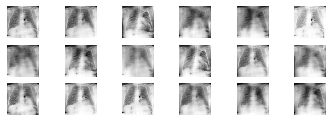

Epoch 175/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6814 - gen_loss: 400.8492


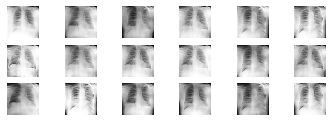

Epoch 176/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6519 - gen_loss: 370.4878


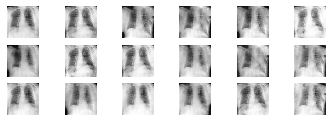

Epoch 177/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.9235 - gen_loss: 421.7617


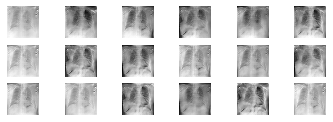

Epoch 178/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.3371 - gen_loss: 325.5466


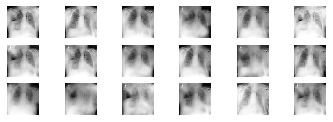

Epoch 179/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.4334 - gen_loss: 301.4285


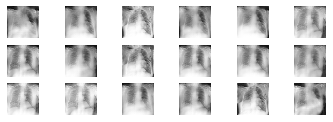

Epoch 180/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -1.0495 - gen_loss: 383.4540


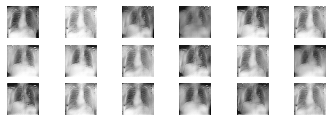

Epoch 181/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -1.1402 - gen_loss: 426.8507


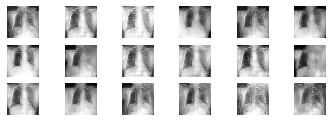

Epoch 182/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.5703 - gen_loss: 397.4137


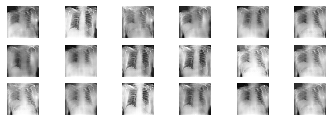

Epoch 183/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.8029 - gen_loss: 476.3253


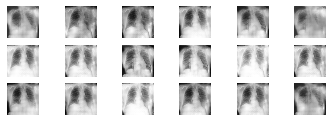

Epoch 184/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -1.3379 - gen_loss: 491.3557


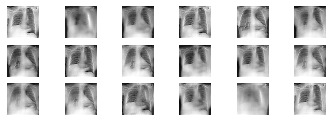

Epoch 185/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -0.8436 - gen_loss: 481.5505


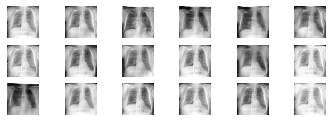

Epoch 186/200
318/318 [==============================] - 144s 453ms/step - disc_loss: -1.0474 - gen_loss: 539.3104


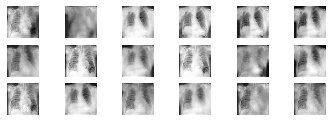

Epoch 187/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.4000 - gen_loss: 394.4986


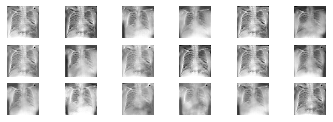

Epoch 188/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6160 - gen_loss: 430.5356


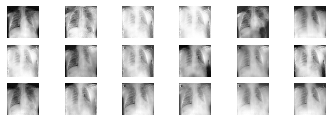

Epoch 189/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.6558 - gen_loss: 432.8201


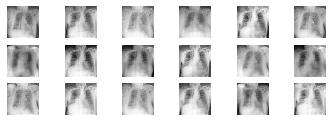

Epoch 190/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -1.9452 - gen_loss: 598.3528


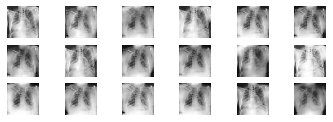

Epoch 191/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.4250 - gen_loss: 460.3024


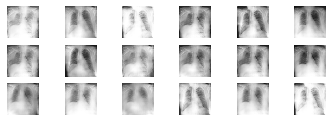

Epoch 192/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -1.0367 - gen_loss: 652.7815


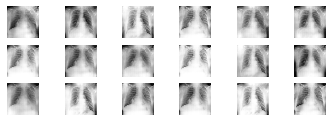

Epoch 193/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.8299 - gen_loss: 575.2235


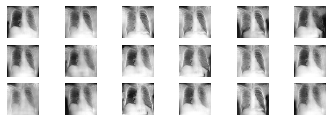

Epoch 194/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.7811 - gen_loss: 558.3139


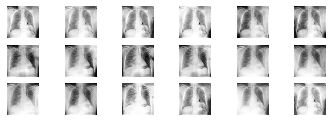

Epoch 195/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -2.1235 - gen_loss: 752.0754


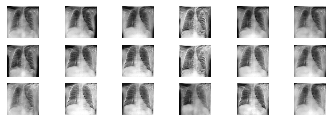

Epoch 196/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -1.1331 - gen_loss: 668.7602


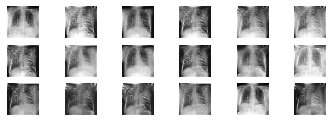

Epoch 197/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -0.9510 - gen_loss: 596.7507


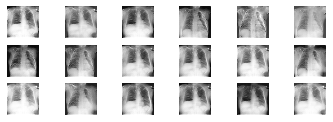

Epoch 198/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -1.2696 - gen_loss: 672.8998


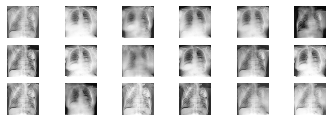

Epoch 199/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -1.4220 - gen_loss: 641.0020


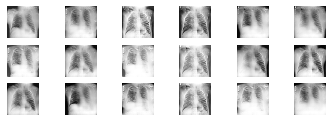

Epoch 200/200
318/318 [==============================] - 144s 452ms/step - disc_loss: -1.5017 - gen_loss: 724.3157


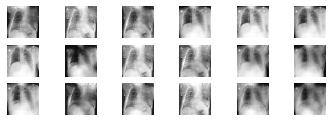

In [ ]:
epochs = 200

gan = GAN(discriminator=discriminator, generator=generator, noise_dim=noise_dim)
gan.compile(
    disc_optimizer=Adam(learning_rate=0.0001),
    gen_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy(),
)

if load_model:
  gan.load_weights(checkpoint_path)
  
gan.fit(data, epochs=epochs, callbacks=[PrintCallback()])



Plot training graphs

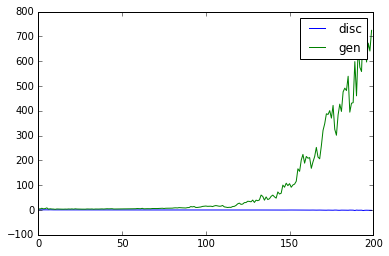

In [ ]:
def plot_loss():
  plt.plot(gan.history.history['disc_loss'], label='disc')
  plt.plot(gan.history.history['gen_loss'], label='gen')
  plt.legend()
  plt.show()

plot_loss()

Generate synthetic images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


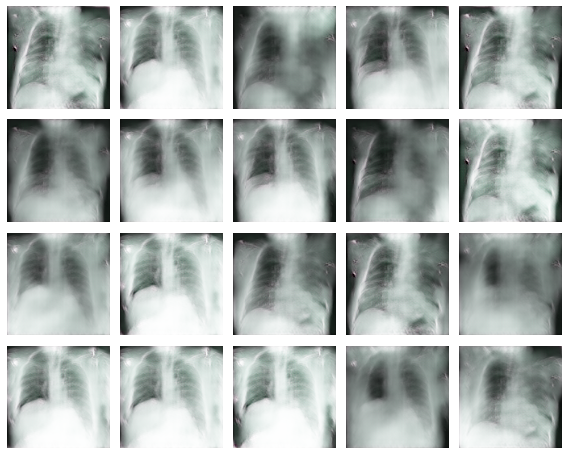

In [ ]:
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(8, 8))
    
    for i, image in enumerate(generated_images):
        plt.subplot(5, 5, i+1)
        plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
noise = np.random.normal(0, 1, size=(20, noise_dim))
show_images(noise)
